In [1]:
%matplotlib notebook

In [2]:
import os
import dicom

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, moments
from skimage.morphology import closing, erosion, square
from skimage.draw import circle
from scipy.signal import medfilt
from scipy.optimize import fmin

def display_dicom(dcm,colormap='gray',colorbar=True):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    cax = ax.imshow(dcm.pixel_array,cmap=plt.get_cmap(colormap))

    if colorbar:
        fig.colorbar(cax)

def parse_dicom_tree(path):
    dcms = dict()
    for fn in os.listdir(path):
        ffn = os.path.join(path,fn)
        if os.path.isfile(ffn):
            try:
                ds = dicom.read_file(ffn)
                snum = ds.SeriesNumber
                if not snum in dcms:
                    dcms[snum] = list()
                dcms[snum].append(ds)
                
            except dicom.errors.InvalidDicomError:
                print("Skipping " + ffn + ", not a DICOM file")
    return dcms

def print_dicom_summary(dcms):
    series = sorted(dcms.keys())
    for s in series:
        print (str(dcms[s][0].SeriesNumber) + '\t' + str(len(dcms[s])) + '\t' + dcms[s][0].SeriesDescription)
        
def label_image(image, threshold_sensitivity=0.1,erosion_size=4):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > threshold_sensitivity*thresh, square(3))
    bw = erosion(bw, square(erosion_size))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = 0
    
    return label_image

def display_labels(label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(label_image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')

        
def display_labels_on_image(image,label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')

        
def calc_flip_angle_map(dcm1,dcm2):
    if dcm1.FlipAngle > dcm2.FlipAngle:
        im_low = dcm2.pixel_array
        im_high = dcm1.pixel_array
        flip_angle_low = dcm2.FlipAngle
        flip_angle_high = dcm1.FlipAngle
    else:
        im_low = dcm1.pixel_array
        im_high = dcm2.pixel_array
        flip_angle_low = dcm1.FlipAngle
        flip_angle_high = dcm2.FlipAngle

    if flip_angle_high != 2*flip_angle_low:
        raise Exception('Low flip angle is not half of high flip angle')
    
    im_low = medfilt(im_low.astype(np.double),5)
    im_high = medfilt(im_high.astype(np.double),5)

    q = im_high/(2*(im_low+np.finfo(np.double).eps))
    q = np.clip(q,-1, 1);
    fa = np.arccos(q)*(180/np.pi);    
    
    #q = im_low/(im_high+np.finfo(np.double).eps)
    #q = np.clip(q,-1, 1);
    #fa = np.arcsin(q)*(180/np.pi);    

    fa = fa/flip_angle_low
    return fa

def get_label_mean(img,label_image,labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)
    
    means = list()
    for l in labels:
        m = (label_image == l).astype(np.double)
        s = np.sum(m*img)/np.sum(m)
        means.append(s)
        
    return means

def get_IR_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TIs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TIs[idx] = im.InversionTime
        
    idx = [i[0] for i in sorted(enumerate(TIs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TIs = TIs[idx]
    
    return TIs, signal

def fit_t1_mag_IR(TIs, IRSignal):
    #Doing 3 parameters fit
    # S = A - B exp(-TI./T1star)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = IRSignal[:,c]
        ss = sorted(enumerate(abs(s)), key=lambda x: x[1])
        if ss[0][0] == 0: 
            T1star = np.min(TIs)/np.log(2);
        else:
            tmp = ss[0:2]
            if tmp[0][0] > tmp[1][0]:
                tmp = [tmp[1], tmp[0]]
            slope = (tmp[1][1] + tmp[0][1])/(TIs[tmp[1][0]]-TIs[tmp[0][0]])
            T1star = (tmp[0][1]/slope + TIs[tmp[0][0]])/np.log(2)
        

        #Next let's do the fit with scipy.optimize.fmin (simplex)
        Ainit = np.max(np.abs(s))
        x0 = [Ainit, 2*Ainit, T1star] 
        costfcn = lambda x: np.sum((np.abs(x[0]-x[1]*np.exp(-TIs/x[2]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
        
    return fits

def get_SE_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TEs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TEs[idx] = im.EchoTime
        
    idx = [i[0] for i in sorted(enumerate(TEs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TEs = TEs[idx]
    
    return TEs, signal

def fit_t2_SE(TEs,signal):
    #Doing s parameters fit
    # S = A exp(-TE./T2)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = signal[:,c]
        y = np.log(np.abs(s))
        x = TEs;
        b = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
        a = np.mean(y) - b*np.mean(x)
        x0 = [np.exp(a), -1/b]

        costfcn = lambda x: np.sum((np.abs(x[0]*np.exp(-TEs/x[1]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
    return fits

def imlist_to_pixel_array(imgs):
    img_size = imgs[0].pixel_array.shape
    img_array = np.zeros((len(imgs), img_size[0],img_size[1]))
    for idx, i in enumerate(imgs):
        img_array[idx,:,:] = i.pixel_array
    return img_array

def read_noise_covariance_matrix(filename):
    f = open(filename,'rb')
    xml_length = np.fromfile(f,dtype=np.uint32,count=1)
    xml_header = f.read(xml_length)
    noise_dwell_time = np.fromfile(f,dtype=np.float32,count=1)
    cov_length = np.fromfile(f,dtype=np.uint64,count=1)
    ndim = np.fromfile(f,dtype=np.uint64,count=1)
    dims = np.fromfile(f,dtype=np.uint64,count=ndim)
    cov_mtx = np.fromfile(f,dtype=np.complex64,count=np.prod(dims))
    cov_mtx = cov_mtx.reshape(dims)
    f.close()
    return cov_mtx

In [15]:
import csv
import re
f = open('/home/hansenms/data/PANDA/NIH_PANDA/DAY7_SPIRAL_SNR/DAT/filelist.csv', 'rt')
reader = csv.reader(f)
spiral_scans = dict()
cartesian_scans = dict()
for row in reader:
    fname = row[0]
    scan_name = re.search('FID[0-9]{5}_([^.]+).dat',fname).group(1)
    scan_info = {'TR':float(row[1]), 'lines': int(row[2]), 'dwell_time': float(row[3]), 'samples': int(row[4])}
    scan_info['frame_time'] = scan_info['TR']*scan_info['lines']
    scan_info['sampling_time'] = scan_info['samples']*scan_info['dwell_time']/1000*scan_info['lines']
    scan_info['sampling_duty_cycle'] = scan_info['sampling_time']/scan_info['frame_time']
    if re.search('CART',scan_name):
        cartesian_scans[scan_name] = scan_info
    elif re.search('SPIR',scan_name):
        spiral_scans[scan_name] = scan_info        
f.close()

In [69]:
spiral_scans

{'SPIR_BW0500_TR1457_I8': {'TR': 14.57,
  'dwell_time': 7.8,
  'frame_time': 116.56,
  'lines': 8,
  'samples': 1624,
  'sampling_duty_cycle': 0.8694028826355524,
  'sampling_time': 101.3376},
 'SPIR_BW0600_TR1252_I8': {'TR': 12.52,
  'dwell_time': 6.5,
  'frame_time': 100.16,
  'lines': 8,
  'samples': 1632,
  'sampling_duty_cycle': 0.8472843450479234,
  'sampling_time': 84.864},
 'SPIR_BW0700_TR1114_I8': {'TR': 11.14,
  'dwell_time': 5.6,
  'frame_time': 89.12,
  'lines': 8,
  'samples': 1648,
  'sampling_duty_cycle': 0.8284380610412926,
  'sampling_time': 73.8304},
 'SPIR_BW0800_TR1010_I8': {'TR': 10.1,
  'dwell_time': 4.9,
  'frame_time': 80.8,
  'lines': 8,
  'samples': 1672,
  'sampling_duty_cycle': 0.8111683168316833,
  'sampling_time': 65.54240000000001},
 'SPIR_BW0800_TR1282_I6': {'TR': 12.82,
  'dwell_time': 4.9,
  'frame_time': 76.92,
  'lines': 6,
  'samples': 2228,
  'sampling_duty_cycle': 0.8515756630265211,
  'sampling_time': 65.5032},
 'SPIR_BW0800_TR1824_I4': {'TR': 18

In [3]:
d = parse_dicom_tree('/home/hansenms/data/PANDA/NIH_PANDA/DAY7_SPIRAL_SNR/DICOM')
print_dicom_summary(d)

1	9	trufi_loc_multi_iPAT
10	1	CART_BW1002_TR0270__GT
11	1	CART_BW1002_TR0270__GT_SNR_MAP
12	1	CART_BW1002_TR0270__GT_Noise_SD_Plot
13	1	CART_BW0908_TR0278__GT
14	1	CART_BW0908_TR0278__GT_SNR_MAP
15	1	CART_BW0908_TR0278__GT_Noise_SD_Plot
16	1	CART_BW0797_TR0294__GT
17	1	CART_BW0797_TR0294__GT_SNR_MAP
18	1	CART_BW0797_TR0294__GT_Noise_SD_Plot
19	1	CART_BW0698_TR0312__GT
20	1	CART_BW0698_TR0312__GT_SNR_MAP
21	1	CART_BW0698_TR0312__GT_Noise_SD_Plot
22	1	CART_BW0601_TR0335__GT
23	1	CART_BW0601_TR0335__GT_SNR_MAP
24	1	CART_BW0601_TR0335__GT_Noise_SD_Plot
25	1	CART_BW0501_TR0368__GT
26	1	CART_BW0501_TR0368__GT_SNR_MAP
27	1	CART_BW0501_TR0368__GT_Noise_SD_Plot
28	1	CART_BW0399_TR0419__GT
29	1	CART_BW0399_TR0419__GT_SNR_MAP
30	1	CART_BW0399_TR0419__GT_Noise_SD_Plot
31	1	CART_BW0300_TR0501__GT
32	1	CART_BW0300_TR0501__GT_SNR_MAP
33	1	CART_BW0300_TR0501__GT_Noise_SD_Plot
34	3	CART_BW0200_TR0668__GT
35	3	CART_BW0200_TR0668__GT_SNR_MAP
36	1	CART_BW0200_TR0668__GT_Noise_SD_Plot
37	3	CART_BW0130_TR09

In [111]:
cartesian_snr_images = [11,14,17,20,23,26,29,32,35,38]
spiral_snr_images = [50,52,54,56,58,60,62,64,66]

<IPython.core.display.Javascript object>


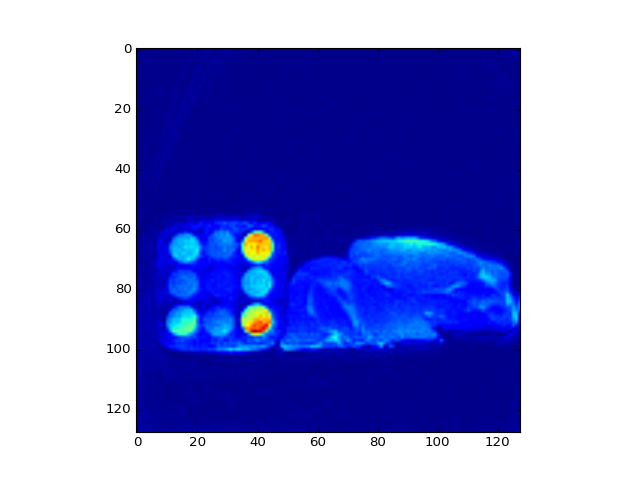

In [112]:
f, ax = plt.subplots(1,1)
img1 = ax.imshow(d[50][0].pixel_array,cmap=plt.cm.jet)

In [19]:
coords = []

def onclick(event):
    coords.append((event.xdata, event.ydata))

    if event.button == 3:
        f.canvas.mpl_disconnect(cid)

cid = f.canvas.mpl_connect('button_press_event', onclick)


In [20]:
coords

[(18.302083333333336, 65.40625),
 (29.302083333333336, 63.40625),
 (42.302083333333336, 65.072916666666671),
 (16.302083333333343, 77.40625),
 (29.302083333333336, 75.739583333333343),
 (41.635416666666679, 77.739583333333343),
 (15.635416666666679, 90.072916666666671),
 (28.635416666666679, 89.40625),
 (40.968750000000007, 89.40625),
 (94.635416666666686, 69.739583333333343),
 (81.302083333333343, 84.40625),
 (55.302083333333336, 92.072916666666671),
 (108.30208333333334, 86.40625)]

In [21]:
radius = 3
labels = np.zeros(d[11][0].pixel_array.shape,dtype=np.int)
for idx,c in enumerate(coords):
    cc,rr = circle(c[1],c[0],radius)
    labels[cc,rr] = idx+1

<IPython.core.display.Javascript object>


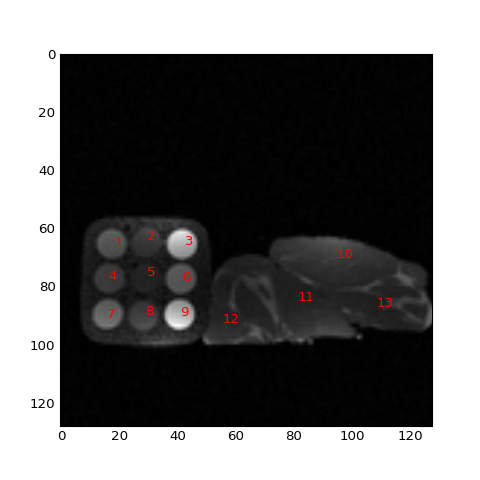

In [22]:
display_labels_on_image(d[11][0].pixel_array,labels)

In [113]:
sample_times_cartesian = list()
regions_cartesian = list()

sample_times_spiral = list()
regions_spiral = list()
tr_spiral = list()
lines_spiral = list()
dwell_time_spiral = list()

for im_series in cartesian_snr_images:
    scan_name = re.search('([A-Z0-9_]+)__GT',d[im_series][0].SeriesDescription).group(1)
    im_pixels = d[im_series][0].pixel_array
    mean_vals = get_label_mean(im_pixels,labels)
    sample_times_cartesian.append(cartesian_scans[scan_name]['sampling_time'])
    regions_cartesian.append(mean_vals)
    
for im_series in spiral_snr_images:
    scan_name = re.search('([A-Z0-9_]+)__GT',d[im_series][0].SeriesDescription).group(1)
    im_pixels = d[im_series][0].pixel_array
    mean_vals = get_label_mean(im_pixels,labels)
    sample_times_spiral.append(spiral_scans[scan_name]['sampling_time'])
    tr_spiral.append(spiral_scans[scan_name]['TR'])
    dwell_time_spiral.append(spiral_scans[scan_name]['dwell_time'])
    lines_spiral.append(spiral_scans[scan_name]['lines'])    
    regions_spiral.append(mean_vals)    

In [114]:
np.sqrt(sample_times_cartesian)

array([ 11.30465391,  11.87023167,  12.67135352,  13.54624671,
        14.59424544,  15.98719488,  17.92      ,  20.63937984,
        25.2779746 ,  31.35346871])

<IPython.core.display.Javascript object>


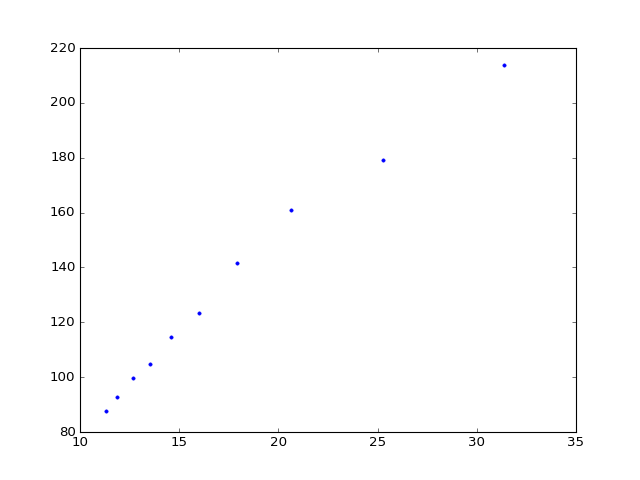

In [120]:
f, ax = plt.subplots(1,1)
ax.plot(np.sqrt(sample_times_cartesian),np.asanyarray(regions_cartesian)[:,0],'.')
#ax.plot(np.sqrt(sample_times_spiral),np.asanyarray(regions_spiral)[:,0],'.r')

<IPython.core.display.Javascript object>


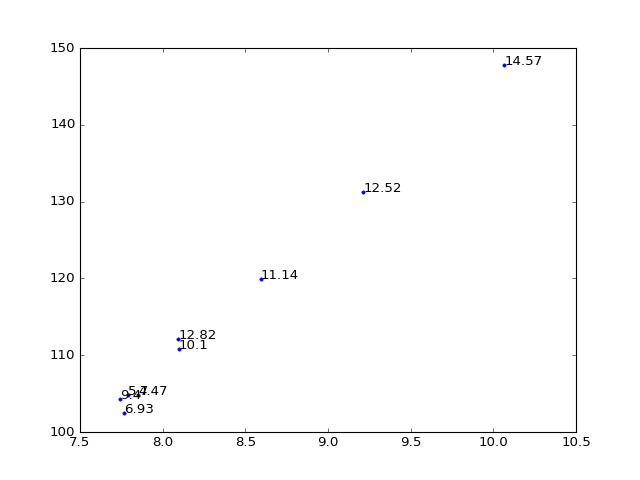

In [119]:
f, ax = plt.subplots(1,1)
A = np.sqrt(sample_times_spiral)
B = np.asanyarray(regions_spiral)[:,0]
ax.plot(A,B,'.')
for idx, xy in enumerate(zip(A, B)):                                    
    ax.annotate('%s'%tr_spiral[idx], xy=xy, textcoords='data')